In [1]:
import random
import pickle
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import cycle

In [37]:
### TO DO
# 1) '(?)' nodes replacement should be done by UM/DM
# 2) Saving final traces to pkl/json


In [2]:
# Trace builiding code
class Trace:
    def __init__(self):
        self.calls = []

class Node_info:
    def __init__(self, num_id, n_type):
        self.num_id = num_id
        self.n_type = n_type

class Call:
    def __init__(self, traceid, timestamp, rpcid, um, dm, rpctype, interface, rt):
        self.traceid = traceid
        self.timestamp = timestamp
        self.rpcid = rpcid
        self.um = um
        self.dm = dm 
        self.rpctype = rpctype
        self.interface = interface
        self.rt = rt
    def string(self):
        return self.traceid + "," + str(self.timestamp) + "," + self.rpcid + "," + self.um + "," + self.dm + "," +\
            self.rpctype + "," + self.interface + "," + str(self.rt)

def csv_to_df(file: str):
    use_columns = list(range(9)) 
    df = pd.read_csv(file,delimiter=',', usecols=use_columns)
    return df

def extract_traceid_rows(df, tid):
    '''
    Returns a list of rpc calls in tid
    '''
    f_df = df[df['traceid'] == tid]
    tid_calls = [
        Call(
            str(row.traceid), 
            int(row.timestamp), 
            str(row.rpcid), 
            str(row.um), 
            str(row.dm), 
            str(row.rpctype), 
            str(row.interface), 
            int(row.rt)
        ) for row in f_df.itertuples(index=False)
    ]
    return tid_calls

def get_call_depth(rpc_id):
    if rpc_id == "0":
        return 1
    else:
        call_depth = 0
        for i in rpc_id:
            if i == ".":
                call_depth += 1
    return call_depth

def save_dict_as_pkl(traces_dict, file_name):
    with open(file_name+'.pkl', 'wb') as pkl_file:
        pickle.dump(traces_dict, pkl_file)

In [3]:
# types :  ['userDefined', 'db', 'http', 'mq', 'rpc', 'mc']
# Extract to dataframe
df = csv_to_df("./casper_rebuild.csv")

# Extract all tids
tids_list = df['traceid'].unique().tolist()
unique_nodes = list(set(df['um'].unique().tolist() + df['dm'].unique().tolist()))
num_traces = len(tids_list)
print("Num of tids (traces): ", num_traces)
print("Num of unique nodes: ", len(unique_nodes))

Num of tids (traces):  10421
Num of unique nodes:  3656


In [4]:
'''
Unknown node error correction
Replace '(?)' with a random node
'''
# Select random ~500 node ids
# sf_nodes_list = df.loc[df['rpctype'] == 'db', 'dm'].to_list()
# sl_nodes_list = df.loc[df['rpctype'] != 'db', 'dm'].to_list()
rand_um_nids = list(df['um'].sample(1500, random_state=1))
rand_dm_nids = list(df['dm'].sample(1500, random_state=1))
rand_um_nids = [um for um in rand_um_nids if um != '(?)']
rand_dm_nids = [dm for dm in rand_dm_nids if dm != '(?)']
replacement_nodes = list(set(rand_um_nids + rand_dm_nids))

# Randomly assign nodeids to unknown nodes
for i in range(len(df)):
    if df.at[i, 'um'] == '(?)':
        df.at[i, 'um'] = random.choice(replacement_nodes)
    if df.at[i, 'dm'] == '(?)':
        df.at[i, 'dm'] = random.choice(replacement_nodes)

tids_list = df['traceid'].unique()
unique_nodes = list(set(df['um'].unique().tolist() + df['dm'].unique().tolist()))
num_traces = len(tids_list)
print('Numbers after Error Correction')
print("Num of tids (traces): ", num_traces)
print("Num of unique nodes: ", len(unique_nodes))

Numbers after Error Correction
Num of tids (traces):  10421
Num of unique nodes:  3655


In [5]:
'''
NIS calc
Node Metrics: [type, NIS]
'''
nis_dict = {}
node_type_dict = {} # Create Node type dict, Key: node id, Val: Type
ctr = 0
for row in tqdm(df.itertuples(), total=len(df)):
    ctr += 1
    um_node = row.um
    dm_node = row.dm

    # Update node type dict for dm_node
    if dm_node not in node_type_dict:
        node_type_dict[dm_node] = row.rpctype

    # Update nis dict for um_node
    if um_node in nis_dict:
        if row.traceid not in nis_dict[um_node]:
            nis_dict[um_node].append(row.traceid)
    else:
        nis_dict[um_node] = [row.traceid]
    # Update nis dict for dm_node
    if dm_node in nis_dict:
        if row.traceid not in nis_dict[dm_node]:
            nis_dict[dm_node].append(row.traceid)
    else:
        nis_dict[dm_node] = [row.traceid]
    # if ctr == 1000:
    #     break
print(len(node_type_dict))
# replace traceid list with NIS
num_traces = 10421 ### TO BE REPLACED
for node in nis_dict:
    nis_dict[node] = set(nis_dict[node])
    nis = len(nis_dict[node])/num_traces ### TO BE REPLACED
    nis_dict[node] = [round(nis,7)]

save_dict_as_pkl(node_type_dict, 'downsampled_graphs/node_type_data')

100%|██████████| 350980/350980 [00:04<00:00, 71009.12it/s] 

3643


In [ ]:
print(nis_dict)
print(len(nis_dict))

In [6]:
'''
Trace metrics calc
Trace Metrics: [trace_depth, TIS, initial_node, num_sf, num_sl]
'''

trace_met_dict = {} # Key: tid, Val: [trace_depth, tis, initial_node, t_sf_ctr, t_sl_ctr]
cd_strat_dict = {} # dict. key: cd, val: [tid ,tis]
# check_unique_nodes = []
for i in tqdm(range(len(tids_list))):
    ctr = 0
    # if i in [0,1,2]:
    #     continue
    tid_calls = extract_traceid_rows(df, tids_list[i])
    initial_node = ""
    t_edges = [] # list of edges of trace
    t_sf_ctr = 0
    t_sl_ctr = 0
    trace_depth = 0
    for call in tid_calls:
        t_edges.append([call.um, call.dm])
        call_depth = get_call_depth(call.rpcid)
        if call_depth > trace_depth: # update trace depth
            trace_depth = call_depth
        if call.rpcid == "0": # get initial node of trace
            initial_node = call.dm
            # print(initial_node)
        if call.rpctype == "db": # get sf sl node count
            t_sf_ctr += 1
        else: 
            t_sl_ctr += 1

    # TIS calculation
    t_nodes = []
    for edge in t_edges:
        for node in edge:
            if node not in t_nodes:
                t_nodes.append(node)
    tis = 0
    for node in t_nodes:
        nis_temp = nis_dict[node][0]
        tis += nis_temp 
    tis = tis/len(t_nodes)

    # Collecting data for stratification
    if trace_depth not in cd_strat_dict:
        cd_strat_dict[trace_depth] = []
    cd_strat_dict[trace_depth].append([tids_list[i],tis])

    trace_met_dict[tids_list[i]] = [trace_depth, tis, initial_node, t_sf_ctr, t_sl_ctr]

    # if ctr == 5:
    #     break
save_dict_as_pkl(trace_met_dict, 'downsampled_graphs/trace_details_data')

100%|██████████| 10421/10421 [02:41<00:00, 64.65it/s]


In [7]:
# G_check = nx.DiGraph()
# G_check.add_edges_from(check)
# print(len(G_check.nodes()))

3655


In [7]:
'''
Stratification
'''

cd_percent_arr = [] # [valid call depth, % of tids of resp cd]
# ctr is used as the total num of tids

# Collecting cd percentage in the original trace
for cd in cd_strat_dict:
    percent_t_cd = 100 * (len(cd_strat_dict[cd])/num_traces)
    cd_percent_arr.append([cd, percent_t_cd])
    cd_strat_dict[cd] = sorted(cd_strat_dict[cd], key=lambda x: x[1], reverse=True) # sorting tids based on tis


In [8]:
cd_percent_arr.sort(key=lambda x: x[0])
print(cd_percent_arr)
res= 0
for i in cd_percent_arr:
    res += i[1]
print(res)

[[0, 0.31666826600134346], [1, 0.8156606851549755], [2, 1.7272814509164187], [3, 16.38038575952404], [4, 30.505709624796083], [5, 18.606659629594088], [6, 8.895499472219557], [7, 3.5313309663180115], [8, 6.47730544093657], [9, 3.185874676134728], [10, 2.303041934555225], [11, 2.293445926494578], [12, 2.638902216677862], [13, 1.4873812494002496], [14, 0.3646483063045773], [15, 0.1919201612129354], [16, 0.11515209672776125], [17, 0.07676806448517416], [18, 0.028788024181940312], [19, 0.01919201612129354], [20, 0.028788024181940312], [21, 0.00959600806064677]]
99.99999999999999


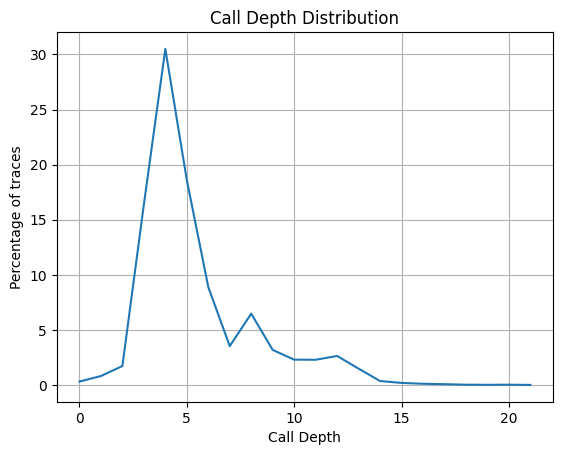

In [12]:
valid_cds = [x[0] for x in cd_percent_arr]
cd_percentages = [x[1] for x in cd_percent_arr]
plt.plot(valid_cds, cd_percentages)
plt.grid(True)
plt.xlabel('Call Depth')
plt.ylabel('Percentage of traces')
plt.title('Call Depth Distribution')
plt.savefig('figs/cd_distribution_from_rpcids.png')
plt.show()

In [19]:
'''
NIS: Priority Sampling
'''
n = 500 # Reduced num of nodes (USER DEFINED)
# Sorted nis_dict based on NIS values
nid_nis_arr = [[nid, nis] for nid, nis in nis_dict.items()]
sorted_node_items = sorted(nid_nis_arr, key=lambda item: item[1], reverse=True)
sampled_nodes = []

for node in sorted_node_items[:n]:
    sampled_nodes.append(node[0])
    
print(len(sampled_nodes))
# nid_nis_arr_sorted_dict = dict(sorted_node_items)
# sampled_nodes = list(nid_nis_arr_sorted_dict.keys()[:n]) # List of selected node ids

500


In [23]:
'''
TIS: Priority Sampling
'''
t_red = 1250 # reduced num of traces (USER DEFINED)
sampled_tids_inter = [] # T_inter


# Priority sampling based on TIS
cd_ctr = 0
for cd in cd_percent_arr: 
    num_traces_to_sample_for_cd = int(t_red * cd[1]/100)
    
    if num_traces_to_sample_for_cd < 1:
        cd_ctr += 1 
        continue
    cd_traces_list = cd_strat_dict[cd[0]]
    cd_priority_sample = cd_traces_list[:num_traces_to_sample_for_cd]
    sampled_cd_tids = [x[0] for x in cd_priority_sample]
    sampled_tids_inter.extend(sampled_cd_tids)
    # print(cd_priority_sample)
print(cd_ctr)

5


In [26]:
print(sampled_tids_inter[:3])

['0b5113ef15919489099687000e6d6b', '0b133c0815919574119565000e5f21', '0b141bcf15919393961062000e1f1f']


In [24]:
'''
NODE PRUNING
Remove all nodes from T_inter that is not in sampled_nodes
'''

def cycle_func(A, B, pred_flag):
    # Cycle through B if it's shorter than A
    B_cycle = cycle(B)
    # Create tuples by pairing elements from A with elements from the cycled B
    if pred_flag == 1: # pred flag is used to check if direction is from pred to succ
        result = [(a, next(B_cycle)) for a in A]
    else:
        result = [(next(B_cycle), a) for a in A]
    return result


def remove_node_with_reconnect(G, node):
    '''
    Remove given node and check if graph breaks. If yes, connect pred nodes
    to succ nodes and then remove given node.
    returns: Updated graph after removing the given node
    '''
    num_comp_before_removal = len(list(nx.weakly_connected_components(G)))
    G_temp = G.copy()
    G_temp.remove_node(node)
    num_comp_after_removal = len(list(nx.weakly_connected_components(G_temp)))

    # If bridge node
    if num_comp_after_removal > num_comp_before_removal:
        pred_nodes = list(G.predecessors(node))
        succ_nodes = list(G.successors(node))
        if len(succ_nodes) == 0 or len(pred_nodes) == 0: # if leaf node
            G.remove_node(node)
            return G
        if len(pred_nodes) >= len(succ_nodes):
            edges_to_add = cycle_func(pred_nodes, succ_nodes, 1)
        else:
            edges_to_add = cycle_func(succ_nodes, pred_nodes, 0)
        for edge in edges_to_add:
            G.add_edge(edge[0], edge[1])
    
    # If not bridge 
    G.remove_node(node)

    return G

def prune_nodes_testy(sampled_tids_inter, sampled_nodes, df):
    '''
    Args: sampled_tids_inter= list of selected trace ids,
          sampled_nodes= list of selected node ids
    Returns: two Dicts(original & pruned); Key=tid, Val=list of edges to build tid
    '''
    T_prime = {}
    T_original = {}
    ctr = 0
    check_unique_nodes = []
    nodes_removed_per_trace = []

    for tid in tqdm(sampled_tids_inter):
        ctr += 1
        nodes_to_remove = []# get list of nodes to remove in trace
        tid_calls = extract_traceid_rows(df, tid)
        t_edges = []
        for call in tid_calls:
            t_edges.append([call.um, call.dm])
            if call.um not in check_unique_nodes:
                check_unique_nodes.append(call.um)
            if call.dm not in check_unique_nodes:
                check_unique_nodes.append(call.dm)
            
        # Build pre-pruned graph
        G = nx.DiGraph()
        G.add_edges_from(t_edges)
        T_original[tid] = t_edges

        # Handling broken graphs (~40% are broken)
        num_comp_before_removal = len(list(nx.weakly_connected_components(G)))
        if num_comp_before_removal > 1:
            # select the largest component
            largest_comp = max(nx.weakly_connected_components(G), key=len)
            G = G.subgraph(largest_comp).copy()
        
        for node in G.nodes():
            if node not in sampled_nodes:
                nodes_to_remove.append(node)
        
        # nodes_to_remove = list(set(nodes_to_remove))
        nodes_removed_per_trace.append(len(nodes_to_remove))

        # Do node pruning
        for node in nodes_to_remove:
            if node in G:
                G = remove_node_with_reconnect(G, node)

        # edges in pruned trace 
        all_edges = list(G.edges())
        T_prime[tid] = all_edges

    print('Unique nodes in selected tids: ', len(check_unique_nodes))
    print('Total nodes removed(sum:max:min): ', sum(nodes_removed_per_trace), ':', max(nodes_removed_per_trace), ':', min(nodes_removed_per_trace))
    # print('Number of broken traces: ', len(broken_traces))
    return T_prime, T_original




In [25]:
# Pruning Check
T_prime, T_original = prune_nodes_testy(sampled_tids_inter, sampled_nodes, df)
# print(len(sampled_nodes))
save_dict_as_pkl(T_prime, 'downsampled_graphs/500nodes_1250traces')

100%|██████████| 1238/1238 [00:19<00:00, 63.73it/s]

Unique nodes in selected tids:  469
Total nodes removed(sum:max:min):  47 : 3 : 0


In [47]:
def buildg_from_tracesdict(traces_dict):

    full_graph_edge_list = []
    for edge_list in traces_dict.values():
        full_graph_edge_list.extend(edge_list)
    G = nx.DiGraph()
    G.add_edges_from(full_graph_edge_list)

    return G

G_prime = buildg_from_tracesdict(T_prime)
G_original = buildg_from_tracesdict(T_original)
print(len(G_original.nodes()))
print(len(G_prime.nodes()))

1024
483


In [48]:
print(len(T_prime))

4988


In [ ]:
# plt.figure(figsize=(8, 6))
# pos = nx.spring_layout(G)  # positions for all nodes

# # Draw nodes
# nx.draw_networkx_nodes(G, pos, node_size=700, node_color='skyblue')

# # Draw edges
# nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrowstyle='->', arrowsize=20)

# len(list(nx.weakly_connected_components(G)))
